<a href="https://colab.research.google.com/github/mikolaj553/Machine-Learning-Homeworks-Repo/blob/main/ml_hw11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Homework #11 - Mikołaj Kowalewski, lab group no. 1**

# 1 Theory Explanation — Transposed Convolutions  

---

## 1.1 Definition and relation to the standard convolution

A transposed convolution is a learnable linear operator that enlarges a feature map while still combining values through a trainable kernel.  
If a standard convolution is written in vectorized form as $\mathbf{y} = \mathbf{W}\,\mathbf{x}$, the transposed convolution computes $\mathbf{x}' = \mathbf{W}^{\!\top}\mathbf{y}$.  
Because $\mathbf{W}^{\!\top}$ has more columns than rows whenever the forward convolution used stride $>1$ or padding $>0$, the result reshapes into a larger spatial grid.

---

## 1.2 Linear-Algebraic and Intuitive Views  

* The operation is literally the matrix transpose of convolution, so the gradient of a convolution with respect to its input is a transposed convolution with the same weights.  
* Instead of sliding a kernel across the input, one may think of the kernel sliding across the output lattice one wishes to create, depositing weighted copies of each input value.  
* Deep learning libraries avoid constructing $\mathbf{W}$ explicitly; they realize the same mapping in three procedural steps described next.

---

## 1.3 How Upsampling Happens — Procedural Recipe  

The upsampling process is described in this section:

## 1.3.0. Notation and Definitions  

* $H_{\text{in}}$, $W_{\text{in}}$ – height and width, respectively, of the input feature map.  
* $k$ – side length of the square convolution kernel.  
* $s$ – integer stride that controls the upsampling factor.  
* $p$ – amount of symmetric zero–padding, which is applied after stride expansion.  
* $H_{\text{out}}$, $W_{\text{out}}$ – height and width of the feature map obtained after the transposed convolution.  

All indices are assumed to start at zero, and the convolution is taken with unit stride once the grid has been expanded.

---

## 1.3.1. Geometric construction

### Step 1 – Zero-Insertion for Stride $s$  

For each original pixel located at coordinates $(i,j)$, replace that pixel by an $s \times s$ block in which the upper-left element retains the original value and the remaining $s-1$ rows and columns of the block are set to zero.  After this operation the intermediate grid attains the dimensions  
$(H_{\text{in}}-1)s + 1 \times (W_{\text{in}}-1)s + 1$.  
This expression reflects the fact that every internal gap between consecutive pixels has been widened from one cell to $s$ cells, while the terminal pixels contribute a single additional row or column.

### Step 2 – Border Padding by $p$  

Surround the stride-expanded grid with a frame consisting of $p$ rows of zeros above and below and $p$ columns of zeros to the left and right.  This padding guarantees that, during convolution, the kernel remains fully contained within valid memory and that the spatial support of each output pixel is centred appropriately.

### Step 3 – Unit-Stride Convolution with the Learned Kernel  

Convolve the padded grid with the $k \times k$ kernel using stride $1$.  The kernel thus visits every contiguous $k \times k$ window that fits inside the padded region, accumulating weighted sums from the mixture of original values and inserted zeros.  The final spatial dimensions are determined deterministically by  

$$
H_{\text{out}} = (H_{\text{in}}-1)\,s - 2p + k, \qquad
W_{\text{out}} = (W_{\text{in}}-1)\,s - 2p + k.
$$  

The term $(H_{\text{in}}-1)s$ (and its width counterpart) accounts for the stride expansion, the subtraction $2p$ removes the artificial margin introduced by padding, and the addition of $k$ restores the extent of the kernel itself.

## 1.3.2 Per-pixel influence during the convolution pass  

During Step 3 each original pixel at position $(r,c)$ in the $H_{\text{in}}\!\times\!W_{\text{in}}$ grid has been relocated to $(r\,s,\;c\,s)$ in the stride-expanded plane.  
When the $k\times k$ kernel slides over that plane, the pixel contributes to every output anchor whose receptive field covers this coordinate:

$$
y_{i,j}
\;=\;
\sum_{u=0}^{k-1}\sum_{v=0}^{k-1}
w_{u,v}\;
x_{\,i+u,\;j+v},
\quad
x_{\,r\,s,\;c\,s}= \text{input}(r,c).
$$

* A single input value can be multiplied by up to $k^2$ different weights $w_{u,v}$ and thereby *spreads* into several neighbouring output pixels.  
* Central output locations receive overlapping contributions from multiple input pixels; border outputs receive fewer because some kernel taps land on padded zeros.  
* The zeros inserted during Step 1 act only as spatial separators—they are multiplied by the kernel but their numeric value is zero, so they vanish in the sum.

Thus a transposed convolution does  just copy pixels; it redistributes each original value across a kernel-shaped footprint, with the exact amplitude pattern controlled by the learned weights.

---

## 1.3.3. Interpretation of the Dimension Formula  

1. The product $(H_{\text{in}}-1)s$ enumerates the number of newly stretched gaps inside the original grid.  
2. The subtraction of $2p$ compensates for the external rows and columns that contain only zeros and do not represent genuine spatial information.  
3. The addition of $k$ re-introduces the reach of the kernel, since each output pixel aggregates values from a window extending $k-1$ positions beyond the anchor point.


---

## 1.4 Roles of $k$, $s$, and $p$  

* Kernel size $k$ sets how far each original pixel’s influence spreads; larger kernels enlarge the receptive field but cost more multiply-adds.  
* Stride $s$ is the principal upsampling factor; for example $s=2$ makes the output almost twice as wide and high.  
* Padding $p$ is applied after zero-insertion; it shifts the receptive field and fine-tunes the output size so that encoder–decoder networks can align shapes perfectly layer by layer.  
* Most frameworks also expose an `output_padding` flag that can add $0$ or $1$ extra row or column when the simple formula misses the target by a single pixel; conceptually this is an implementation convenience rather than a mathematical parameter.

### Summary

A transposed convolution is simply the linear transpose of the convolution operator, realised by zero-insertion, optional padding, and a unit-stride convolution. This construction yields an upsampling layer whose spatial resolution and receptive field are fully determined by the kernel size, stride, and padding hyper-parameters while remaining differentiable and learnable end-to-end.


---

#2. Example

The sketches below walk through every geometric stage of a transposed-convolution layer with kernel = 3, stride = 2, and padding = 1.



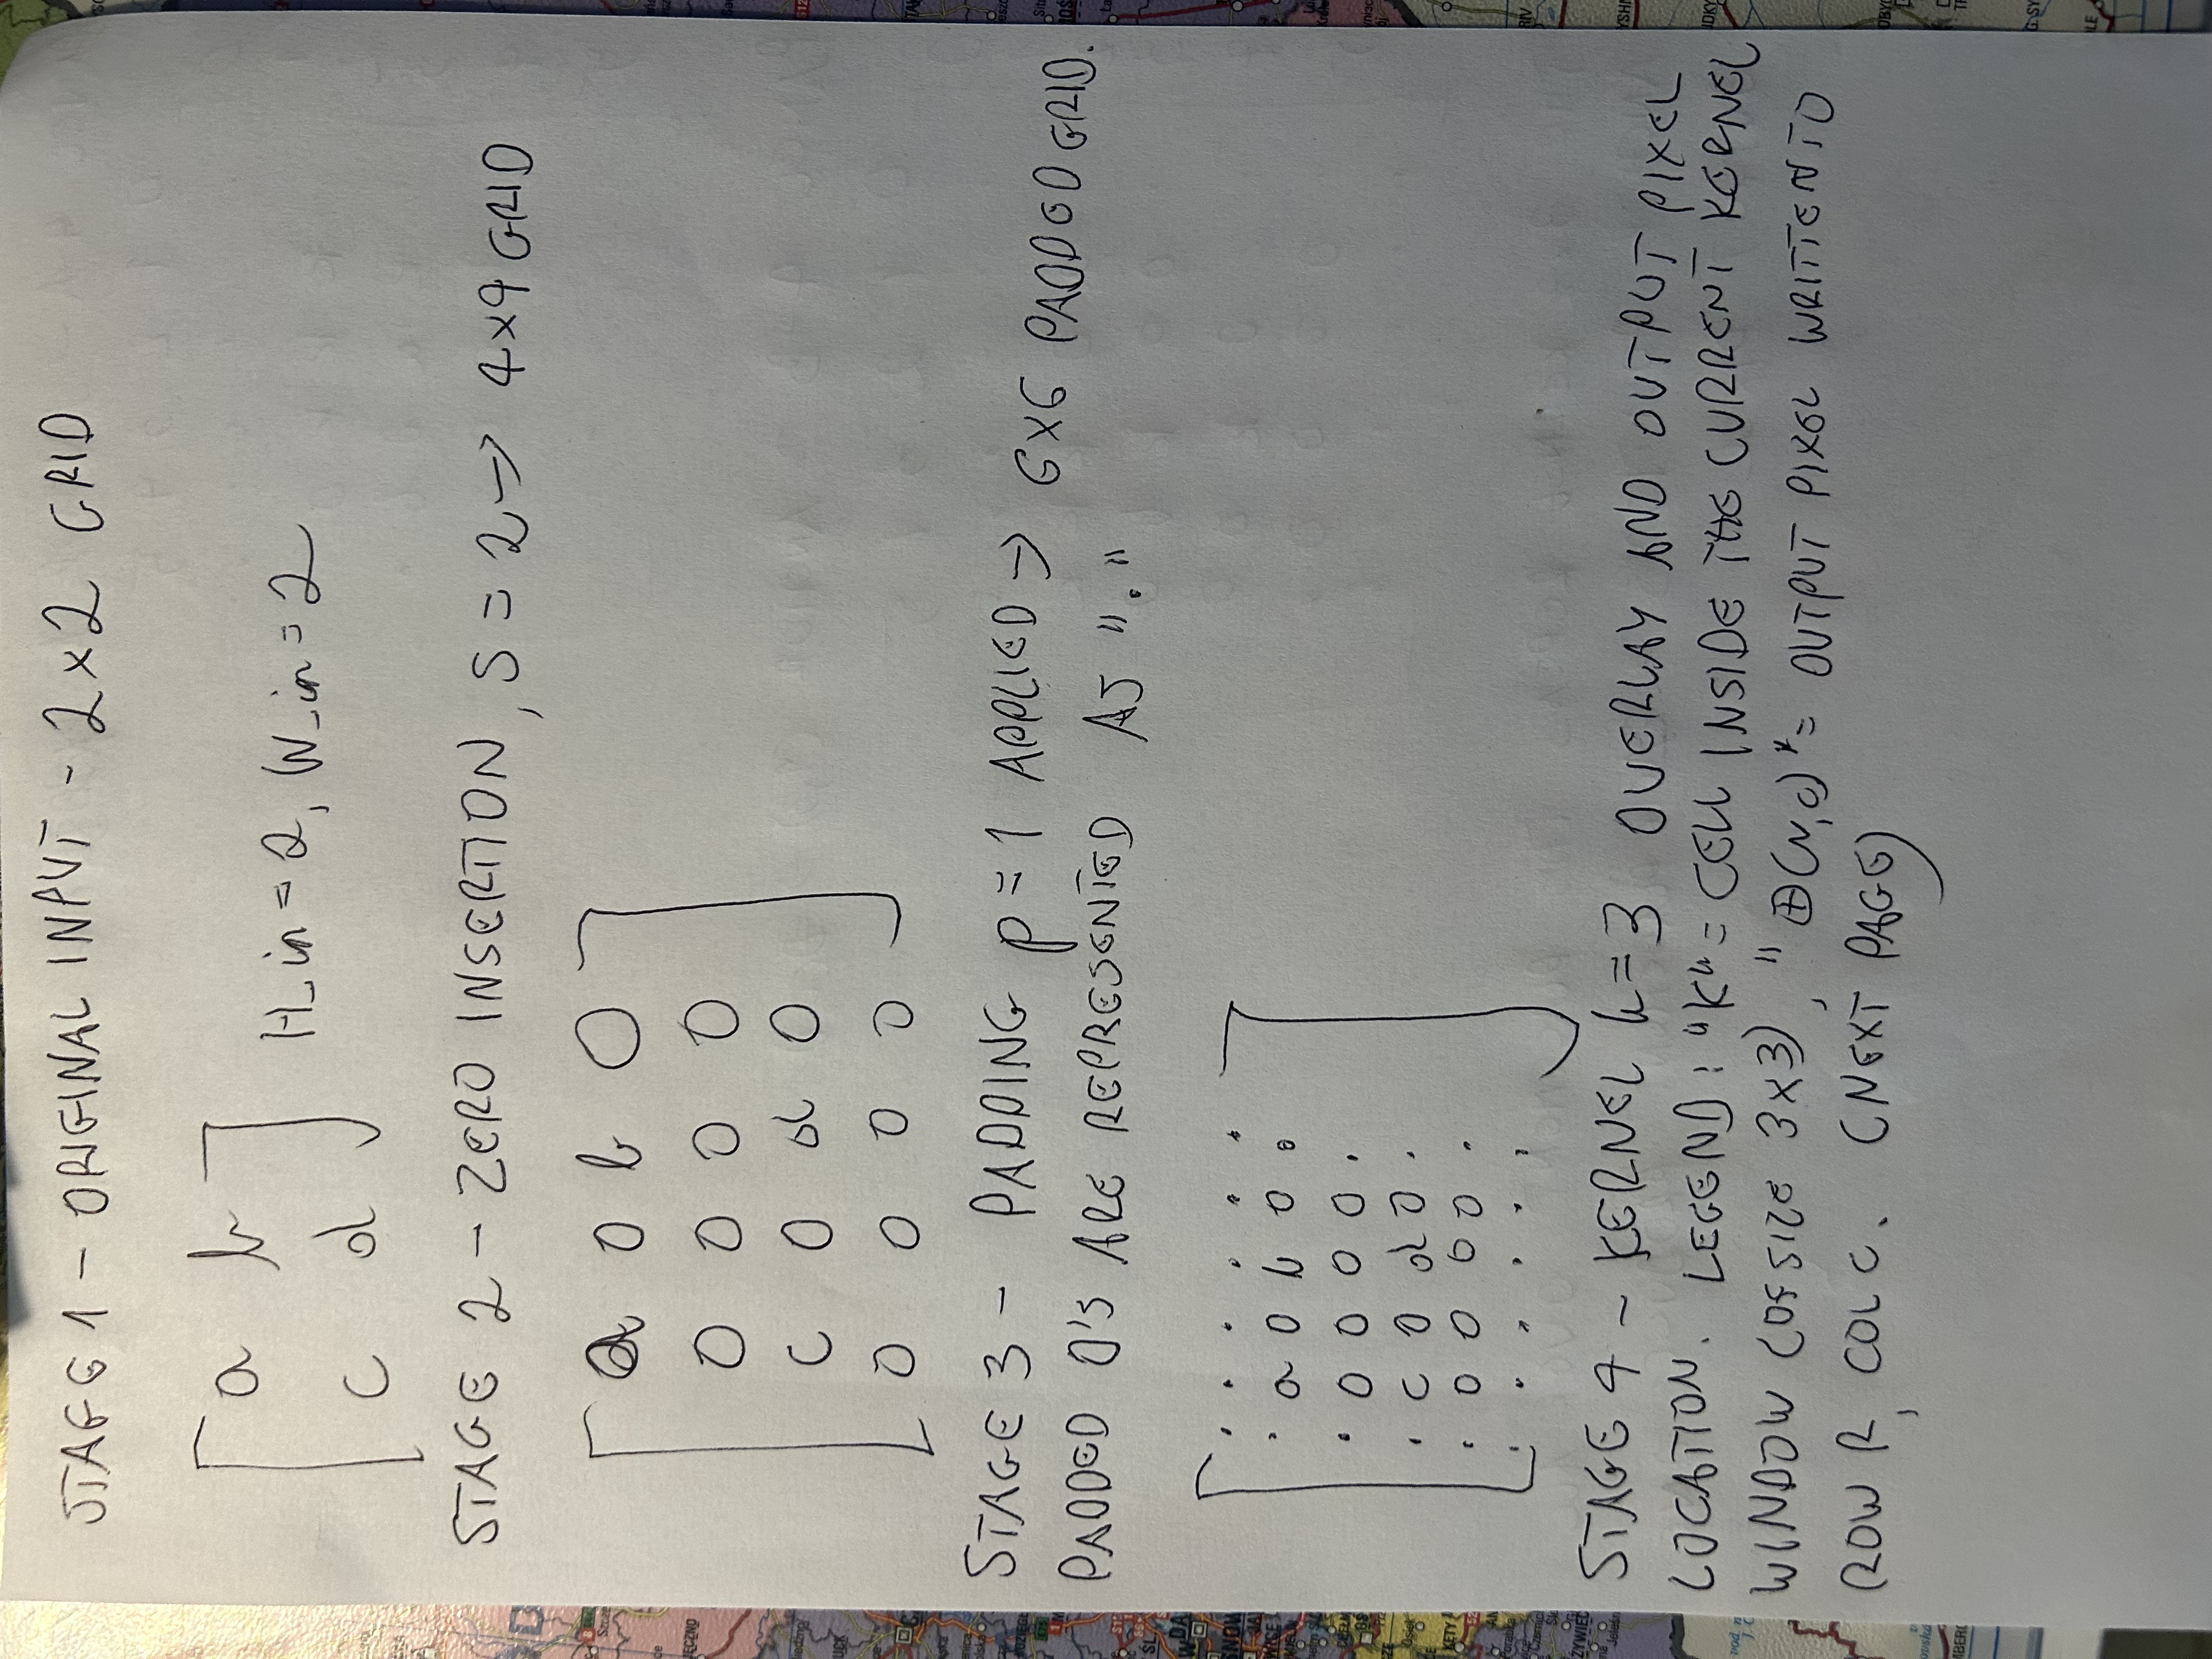

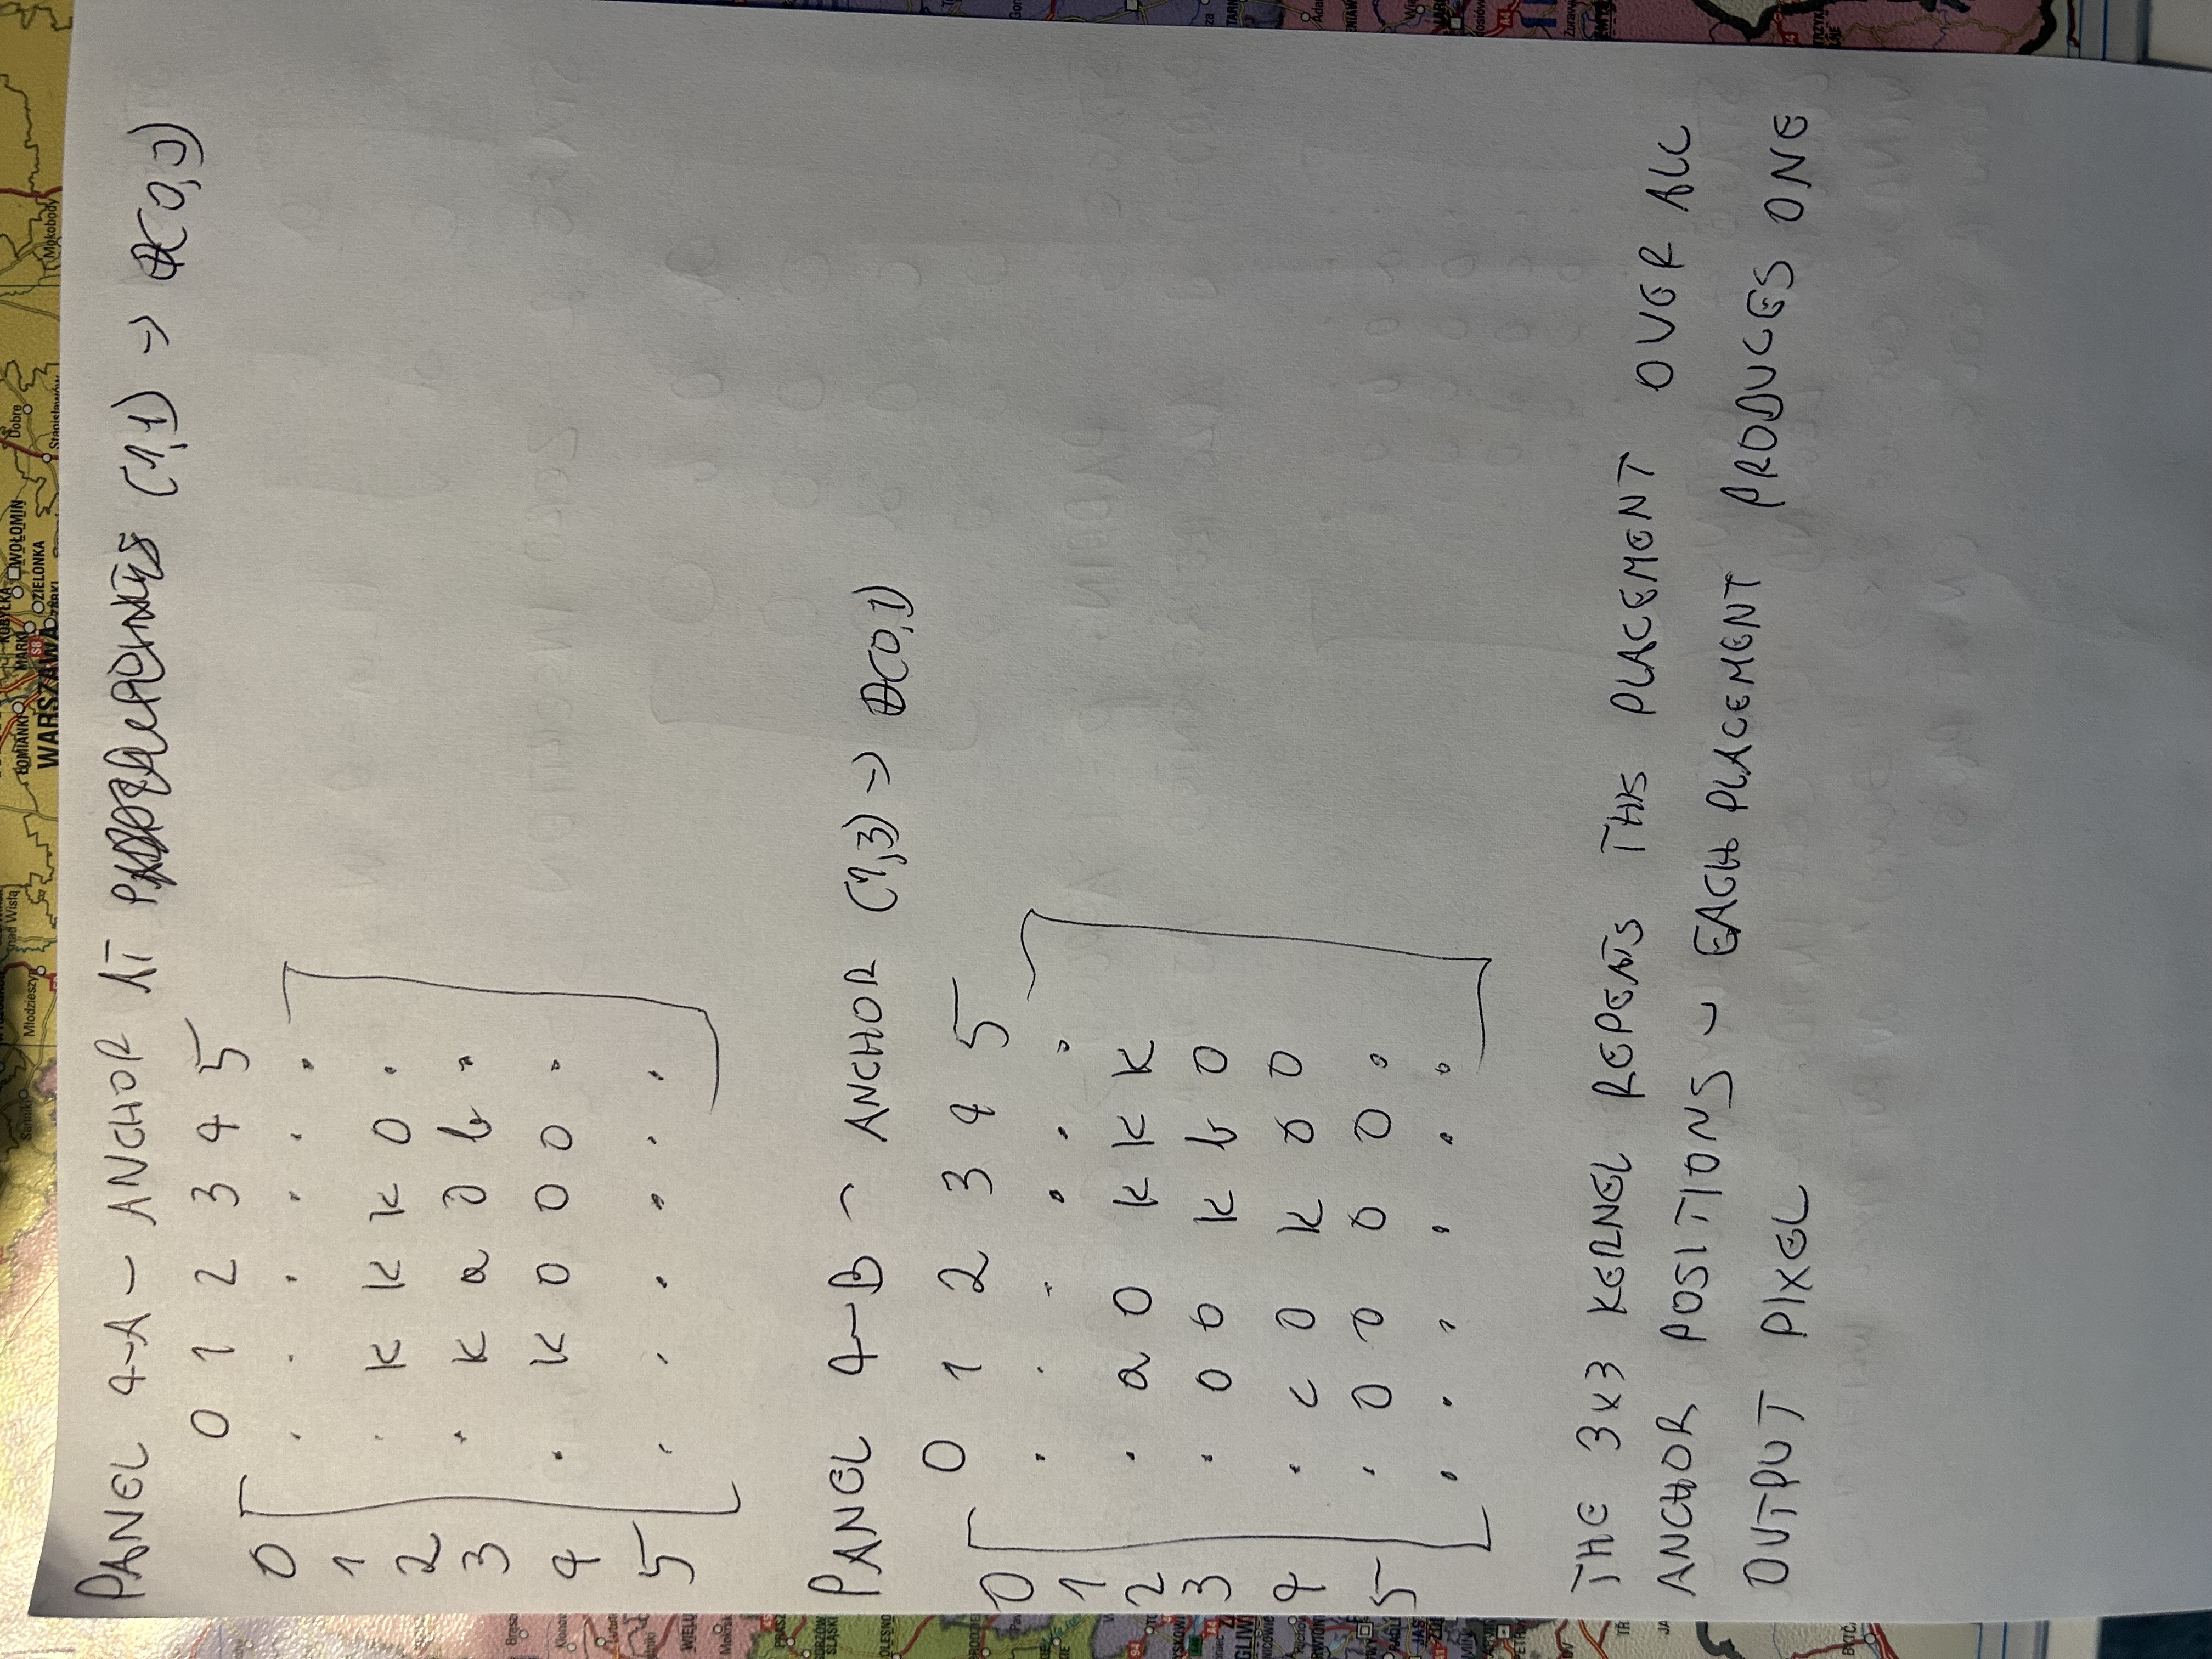